In [1]:
import numpy as np
import pandas as pd
import torch 
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn, optim
###look for this
from torchvision import transforms as T, datasets, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm.autonotebook import tqdm

In [2]:
train_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/"
val_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/"

In [3]:
TRAIN = 'train'
VAL = 'val'

In [4]:
def data_transform(phase = None):
    if phase == TRAIN:
        data_T = T.Compose([
            T.Resize(size = (256,256)),
            T.RandomRotation(degrees = (-20,20)),
            T.CenterCrop(size = 224),
            T.ToTensor(),
            T.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        ])
        
    elif phase == VAL:
        data_T = T.Compose([
            T.Resize(size = (224,224)), 
            T.ToTensor(), 
            T.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        ])
        
    return data_T

In [5]:
trainset = datasets.ImageFolder(train_loc, transform = data_transform(TRAIN))
validset = datasets.ImageFolder(val_loc, transform = data_transform(VAL))

In [6]:
class_name = trainset.classes
print(class_name)
print(trainset.class_to_idx)

['covid', 'normal', 'pneumonia']
{'covid': 0, 'normal': 1, 'pneumonia': 2}


In [7]:
def get_class_count(dataset):
    class_name = dataset.classes
    classes = []
    for _,labels in tqdm(dataset):
        classes.append(class_name[labels])
    return classes

100%|██████████| 17958/17958 [04:07<00:00, 72.57it/s]


Text(0.5, 1.0, 'Train_set')

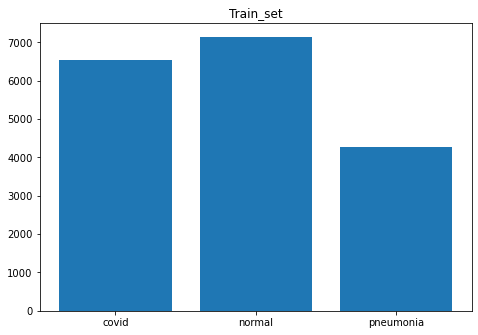

In [11]:
count = get_class_count(trainset)
unique, counts = np.unique(count, return_counts=True)
dict(zip(unique, counts))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(unique,counts)
ax.set_title("Train_set")

100%|██████████| 3432/3432 [00:51<00:00, 66.82it/s] 


Text(0.5, 1.0, 'valid_set')

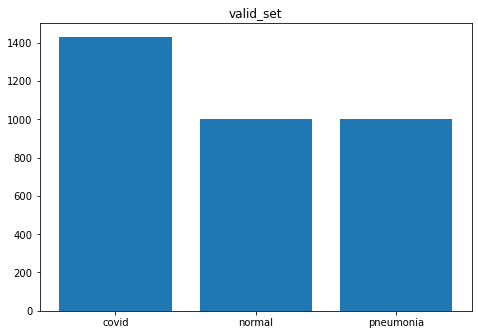

In [12]:
count = get_class_count(validset)
unique, counts = np.unique(count, return_counts=True)
dict(zip(unique, counts))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(unique,counts)
ax.set_title("valid_set")

In [8]:
trainloader = DataLoader(trainset,batch_size = 64,shuffle = True)
validloader = DataLoader(validset,batch_size = 32,shuffle = False)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [10]:
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 3),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

for param in resnet50.parameters():
    param.require_grad = True


In [11]:
model = resnet50
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)
epochs = 100
valid_loss_min = np.Inf


In [13]:
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


In [15]:
train_loss_hist = []
valid_loss_hist = []
train_acc_hist = []
valid_acc_hist = []


for i in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 
    
    
    model.train()
    
    for images,labels in tqdm(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        ps = model(images)
        loss = criterion(ps,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy(ps,labels)
        train_loss += loss.item()
        
    avg_train_acc = train_acc / len(trainloader)
    train_acc_hist.append(avg_train_acc)
    avg_train_loss = train_loss / len(trainloader)
    train_loss_hist.append(avg_train_loss)
        
    model.eval()
    with torch.no_grad():
        
        for images,labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            ps = model(images)
            loss = criterion(ps,labels)
            
            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()
            
            
        avg_valid_acc = valid_acc / len(validloader)
        valid_acc_hist.append(avg_valid_acc)
        avg_valid_loss = valid_loss / len(validloader)
        valid_loss_hist.append(avg_valid_loss)
        
        schedular.step(avg_valid_loss)
        
        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'Resnet50_100_epochs.pt')
            
            valid_loss_min = avg_valid_loss
            
            
    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))


  0%|          | 0/281 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Inference on Validation set of the best model

In [12]:
saved_model = torch.load("./baseline_2_model.pt")

In [14]:
model.load_state_dict(saved_model['model_state_dict'])

<All keys matched successfully>

In [22]:
model.eval()

test_loss = 0
test_acc = 0

for images,labels in tqdm(validloader):
    
    images = images.to(device)
    labels = labels.to(device)
    
    pred = model(images)
#     loss = criterion(pred,labels)
    
#     test_loss += loss.item()
    test_acc += accuracy(pred,labels)
    
# avg_test_loss = test_loss/len(validloader)
avg_test_acc = test_acc/len(validloader)


  0%|          | 0/429 [00:00<?, ?it/s]

In [31]:
print(f"Accuracy: {avg_test_acc.item()*100} %%!")

Accuracy: 91.08391404151917 %%!


#### Confusion Matrix

In [37]:
import seaborn as sns

In [35]:
nb_classes = 3
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in tqdm(enumerate(validloader)):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

0it [00:00, ?it/s]

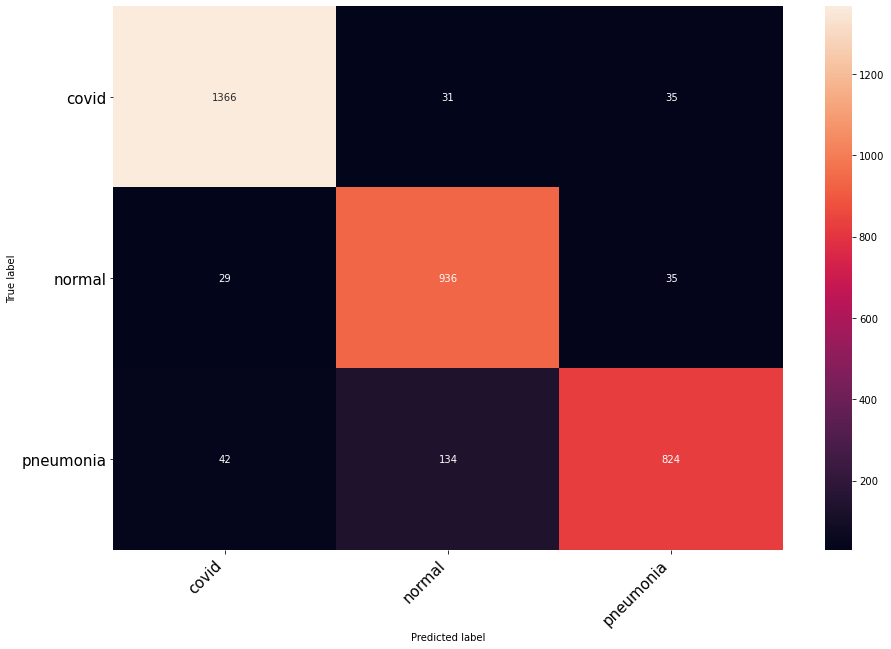

In [45]:
plt.figure(figsize=(15,10))

class_names = validloader.dataset.classes
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("/media/brats/DRIVE1/akansh/DeepXrays/Figures/baseline_resnet50_20epochs.png")